
Log: Czyszczenie nazw kolumn ze znaków specjalnych...
Log: Dane gotowe. Model B będzie uczył się na 39 zmiennych.
Log: Pomyślnie wczytano wyniki Modelu A.
Log: Rozpoczynanie treningu modelu XGBoost...


c:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:34:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Log: Model XGBoost został wytrenowany pomyślnie!
Log: Generowanie prognoz...

--- WYNIKI POJEDYNKU MODELI ---
Model A (Benchmark - FICO): AUC = 0.5934
Model B (Challenger - ML):  AUC = 0.6966
---------------------------------------
Poprawa (Lift):            +0.1032


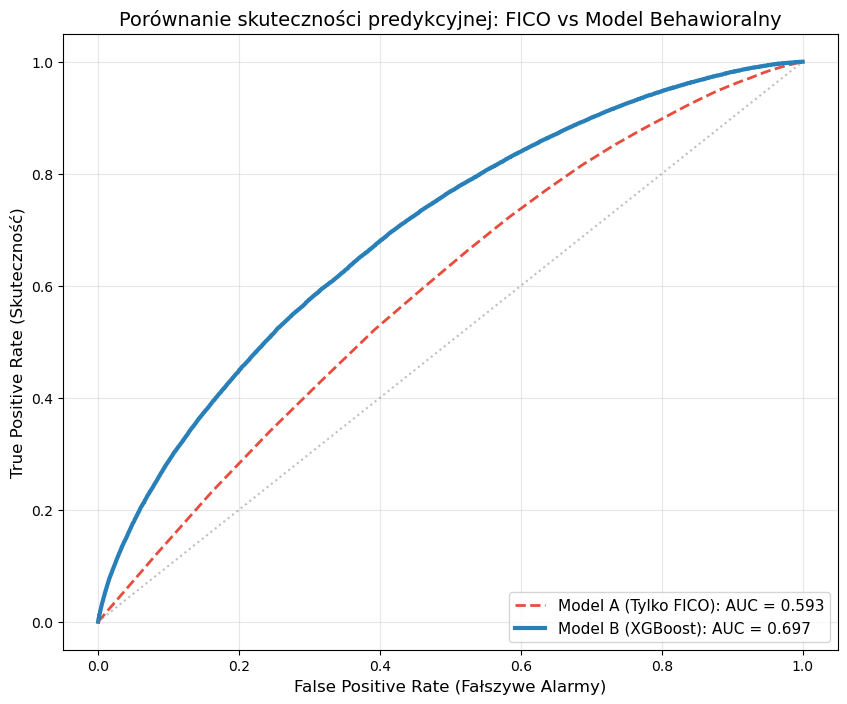

<Figure size 1000x800 with 0 Axes>

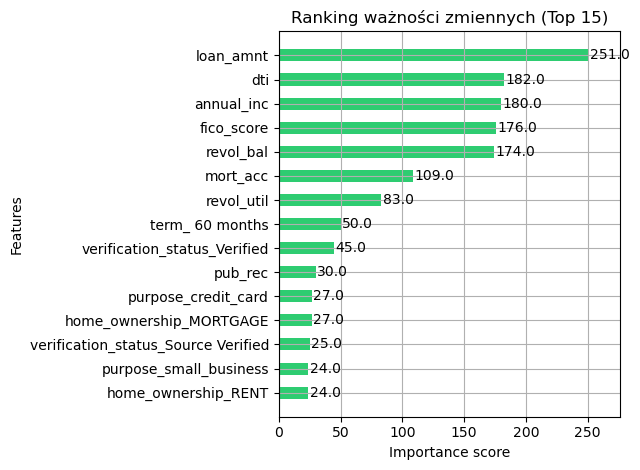


Log: Procedura zakończona sukcesem.


In [4]:
!pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
import os

# --- 1. IMPORT DANYCH ---
print("Log: Wczytywanie pełnych zbiorów danych...")

X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv').values.ravel()
y_test = pd.read_csv('../data/y_test.csv').values.ravel()

# --- 2. SANITYZACJA NAZW KOLUMN (NAPRAWA BŁĘDU VALUEERROR) ---
# XGBoost nie akceptuje znaków: <, [, ] w nazwach kolumn.
# Zmieniamy je na bezpieczne odpowiedniki.

print("Log: Czyszczenie nazw kolumn ze znaków specjalnych...")
# Zmieniamy '<' na 'lt' (less than) oraz nawiasy na zwykłe
X_train.columns = X_train.columns.str.replace('<', 'lt').str.replace('[', '(').str.replace(']', ')')
X_test.columns = X_test.columns.str.replace('<', 'lt').str.replace('[', '(').str.replace(']', ')')

print(f"Log: Dane gotowe. Model B będzie uczył się na {X_train.shape[1]} zmiennych.")

# Wczytanie wyników modelu A (dla porównania)
try:
    probs_a = np.load('../data/probs_model_a.npy')
    print("Log: Pomyślnie wczytano wyniki Modelu A.")
except FileNotFoundError:
    print("OSTRZEŻENIE: Brak wyników Modelu A. Wykres porównawczy będzie niepełny.")
    probs_a = np.zeros(len(y_test))

# --- 3. TRENING XGBOOST ---
print("Log: Rozpoczynanie treningu modelu XGBoost...")

model_b = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    scale_pos_weight=4,     # Balansowanie klas
    eval_metric='auc',
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False
)

model_b.fit(X_train, y_train)
print("Log: Model XGBoost został wytrenowany pomyślnie!")

# --- 4. EWALUACJA I WYNIKI ---
print("Log: Generowanie prognoz...")

probs_b = model_b.predict_proba(X_test)[:, 1]

auc_score_b = roc_auc_score(y_test, probs_b)
auc_score_a = roc_auc_score(y_test, probs_a)
lift = auc_score_b - auc_score_a

print(f"\n--- WYNIKI POJEDYNKU MODELI ---")
print(f"Model A (Benchmark - FICO): AUC = {auc_score_a:.4f}")
print(f"Model B (Challenger - ML):  AUC = {auc_score_b:.4f}")
print(f"---------------------------------------")
print(f"Poprawa (Lift):            +{lift:.4f}")

# --- 5. WIZUALIZACJA: CHAMPION VS CHALLENGER ---

fpr_a, tpr_a, _ = roc_curve(y_test, probs_a)
fpr_b, tpr_b, _ = roc_curve(y_test, probs_b)

plt.figure(figsize=(10, 8))
plt.plot(fpr_a, tpr_a, color='#e74c3c', linestyle='--', lw=2, label=f'Model A (Tylko FICO): AUC = {auc_score_a:.3f}')
plt.plot(fpr_b, tpr_b, color='#2980b9', lw=3, label=f'Model B (XGBoost): AUC = {auc_score_b:.3f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle=':', alpha=0.5)

plt.xlabel('False Positive Rate (Fałszywe Alarmy)', fontsize=12)
plt.ylabel('True Positive Rate (Skuteczność)', fontsize=12)
plt.title('Porównanie skuteczności predykcyjnej: FICO vs Model Behawioralny', fontsize=14)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)

if not os.path.exists('../figures'):
    os.makedirs('../figures')
plt.savefig('../figures/05_roc_comparison.png')
plt.show()

# --- 6. RANKING ZMIENNYCH ---
plt.figure(figsize=(10, 8))
xgb.plot_importance(model_b, max_num_features=15, height=0.5, importance_type='weight', color='#2ecc71', title='Ranking ważności zmiennych (Top 15)')
plt.tight_layout()
plt.savefig('../figures/06_feature_importance.png')
plt.show()

np.save('../data/probs_model_b.npy', probs_b)
print("\nLog: Procedura zakończona sukcesem.")

Przeprowadzony eksperyment wykazał znaczącą przewagę modelu opartego na uczeniu maszynowym (XGBoost) nad tradycyjnym podejściem wykorzystującym wyłącznie ocenę biura kredytowego.

Model behawioralny (Model B) osiągnął współczynnik AUC na poziomie 0.6966, co stanowi istotny wzrost skuteczności względem modelu referencyjnego (AUC = 0.5934). Zanotowany przyrost jakości predykcyjnej (Lift) wynosi +0.1032.

W ujęciu biznesowym oznacza to, że włączenie do analizy zmiennych dochodowych (takich jak DTI czy roczny dochód) oraz charakterystyki kredytu pozwala na znacznie precyzyjniejszą identyfikację klientów zagrożonych niewypłacalnością, których tradycyjny scoring FICO błędnie zaklasyfikowałby jako wiarygodnych.

Na Rysunku 5 przedstawiono zestawienie krzywych ROC obu modeli. Wyraźna separacja krzywej niebieskiej (Model B) od krzywej czerwonej (Model A) obrazuje "wartość dodaną" zastosowania algorytmów Machine Learning. Model B charakteryzuje się znacznie wyższą czułością (True Positive Rate) przy zachowaniu tego samego poziomu fałszywych alarmów, co pozwala na bezpieczniejsze zwiększenie akcji kredytowej.

W celu zrozumienia źródeł przewagi modelu XGBoost nad tradycyjnym scoringiem, przeprowadzono analizę ważności zmiennych (Feature Importance), opartą na częstotliwości wykorzystania poszczególnych cech w podziałach drzew decyzyjnych (Rysunek 6).

Wyniki analizy są zaskakujące i podważają dominującą rolę zewnętrznych ocen kredytowych. Zmienna fico_score, będąca jedynym elementem modelu referencyjnego, zajęła dopiero czwartą pozycję w rankingu istotności.

Kluczowymi determinantami ryzyka w badanym portfelu okazały się zmienne o charakterze dochodowym i transakcyjnym, które nie są uwzględniane w algorytmie FICO:

* Kwota kredytu (`loan_amnt`): Najsilniejszy predyktor. Wskazuje to, że w segmencie pożyczek wysokiego ryzyka (P2P), "ciężar" zobowiązania ma większe znaczenie niż historyczna rzetelność dłużnika.

* Wskaźnik DTI (`dti`): Drugi najważniejszy czynnik, obrazujący bieżące obciążenie budżetu domowego klienta.

* Roczny dochód (`annual_inc`): Trzeci kluczowy parametr, bezpośrednio powiązany ze zdolnością do obsługi długu.

Dominacja tych trzech zmiennych potwierdza, że skuteczna ocena ryzyka w nowoczesnym fintechu wymaga wyjścia poza analizę historii kredytowej (credit history) w stronę analizy bieżącej płynności finansowej (affordability).
